# Домашнее задание №1

В первом ДЗ мы создаём и обустраиваем git-репозиторий, который будем использовать в дальнейшем, загружаем данные о ц.б. SNP500 и криптовалютах, настраиваем автоматическое отображение графиков котировок и частично проводим предобработку и анализ данных. Для того, чтобы всё сделать правильно, я создал небольшой чек-лист ДЗ1, который Вы видите ниже:

~~1. **Создать git-репозиторий**, где будет храниться исходный код вашего проекта. Если вы используете приватный репозиторий – дайте преподавателям курса доступ к нему, для возможности проверки ДЗ.~~ *(Использовал публичный репозиторий)*

~~2.  **Добавить файл лицензии**, который отражает ваш взгляд на конфиденциальность информации, которую вы подготовите в рамках данного курса.~~ \
\
~~3. **Создать код на Python**, который загрузит на ваш локальный компьютер данные о:\
    a) котировках ценных бумаг из списка **SnP500**; \
    b) котировки **криптовалют** (BTC, ETH, SOL, XRP).~~ \
\
~~4. Поскольку вам предстоит много работать с ними в дальнейшем, подготовьте **автоматическое отображение графиков** текущей ситуации.~~ \
\
~~5.  a) Проверьте нет ли в данных **пропусков или ошибок**;~~ *(ошибок нет, пропуски обработал)* \
    b) Проанализируйте **выбросы**; \
    c) Оцените, на самом ли деле это **выбросы или реальные данные**, с которыми предстоит работать. 

*Примечание: поскольку первые два шага делаются вне этого ноутбука, нумерация разделом начинается с цифры "3"*

## 0: Импорты

In [1]:
##%pip install pandas
##%pip install requests
##%pip install bs4
#%pip install yfinance --upgrade --no-cache-dir
#%pip install plotly
#%pip install nbformat --upgrade
#%pip install ipywidgets
#%pip install matplotlib

In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly
import yfinance as yf
import datetime
import matplotlib as mpl

In [3]:
# использую warnings, чтобы заглушить предупреждения Pandas в нескольких местах в моей работе
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## 3: Загрузка данных

### 3.a: Загрузка данных о компаниях SNP500

In [4]:
url = 'https://en.m.wikipedia.org/wiki/List_of_S%26P_500_companies' # ссылка на страницу Википедии с тикерами всех компаний индекса SNP500

# собираю тикеры всех компаний из SNP500 в список tickers_snp
tickers_df = pd.read_html(url, attrs={'id': 'constituents'}, index_col='Symbol')[0]
tickers_snp = tickers_df.index.to_list()

*Примечание: я нашёл, как загрузить все тикеры акций SNP500, и реализовал выше; но решил в проекте использовать только 5 с наибольшей рыночной капитализцией (а значит, с самым большим весом в индексе), поскольку работать с данными придётся вручную*

In [5]:
tickers_snp_top5 = ["AAPL", "NVDA", "MSFT", "AMZN", "GOOG"]

In [6]:
# с помощью yfinance скачиваю данные о топ-5 компаниях индекса SNP500 и кладу их в датафрейм df_snp
df_snp = yf.download(tickers=tickers_snp_top5,
                     period="1mo",
                     interval="15m",
                     group_by="ticker")
df_snp.index = pd.to_datetime(df_snp.index)

[*********************100%***********************]  5 of 5 completed


In [7]:
# отбрасываю колонку adjusted close, содержащую цену закрытия, модифицированную с учётом дивидендов и прочих выплат
df_snp.drop("Adj Close", inplace=True, axis=1, level=1)

### 3.b: Загрузка данных о криптовалютах (BTC, ETH, SOL, XPR)

In [8]:
tickers_ccur = ["BTC-USD", "ETH-USD", "SOL-USD", "XPR-USD"] # список с тикерами криптовалют

In [9]:
# с помощью yfinance скачиваю данные о криптовалютах и кладу их в датафрейм df_ccur
df_ccur = yf.download(tickers=tickers_ccur,
                      period="1mo",
                      interval="15m",
                      group_by="ticker")
df_ccur.index = pd.to_datetime(df_ccur.index)

[*********************100%***********************]  4 of 4 completed


In [10]:
# отбрасываю колонку adjusted close, содержащую цену закрытия, модифицированную с учётом дивидендов и прочих выплат
df_ccur.drop("Adj Close", inplace=True, axis=1, level=1)

In [11]:
# создаю простые графики с ценами закрытия для Apple и BTC, чтобы удостовериться, что загрузка данных прошла успешно

fig = go.Figure(layout={"margin" : {"b" : 10, "l" : 5, "t" : 10}})
figwid = go.FigureWidget(fig)

figwid.add_trace(go.Scatter(x=df_snp.index,
                         y=df_snp[("AAPL", "Close")],
                         mode="lines",
                         name="Цена закрытия Apple",
                         showlegend=True,
                         line={"color" : "#171CC9"}))
figwid.show()

figwid.data = []
figwid.add_trace(go.Scatter(x=df_ccur.index,
                         y=df_ccur[("BTC-USD", "Close")],
                         mode="lines",
                         name="Цена закрытия BTC",
                         showlegend=True,
                         line={"color" : "#814E1D"}))
figwid.show()

## 4) Заполнение пропусков, создание загрузчика и вывод графиков

### 4.a) Заполнение пропусков

In [12]:
df_joined = pd.concat([df_snp, df_ccur], axis=1)
df_joined.isna().sum()

Ticker   Price 
AMZN     Open      2360
         High      2360
         Low       2360
         Close     2360
         Volume    2360
NVDA     Open      2360
         High      2360
         Low       2360
         Close     2360
         Volume    2360
MSFT     Open      2360
         High      2360
         Low       2360
         Close     2360
         Volume    2360
AAPL     Open      2360
         High      2360
         Low       2360
         Close     2360
         Volume    2360
GOOG     Open      2360
         High      2360
         Low       2360
         Close     2360
         Volume    2360
BTC-USD  Open        13
         High        13
         Low         13
         Close       13
         Volume      13
ETH-USD  Open        13
         High        13
         Low         13
         Close       13
         Volume      13
XPR-USD  Open        13
         High        13
         Low         13
         Close       13
         Volume      13
SOL-USD  Open        13


*Поскольку для построения практически всех индикаторов данные должны быть без пропусков, я решил первым делом заполнить пропуски*

Пропуски - это данные об акциях из SNP500 за период с 15:30 до 9:30 следующего дня (не включая выходные), поскольку в это время акции не торгуются, а криптовалюты торгуются. Поэтому заполним пропуски следующим образом:
* Close - с помощью ffill "перенесём предыдущее известное значение
* Open, High, Low - приравняем к Close
* Volume - поскольку торгов не было, зададим его равным нулю

In [13]:
empty_rows = df_joined.isna().index
for col in df_snp.columns.get_level_values(0):
    df_joined[(col, "Close")].ffill(inplace=True)
    df_joined.loc[empty_rows, (col, "Open")] = df_joined.loc[empty_rows, (col, "Close")]
    df_joined.loc[empty_rows, (col, "High")] = df_joined.loc[empty_rows, (col, "Close")]
    df_joined.loc[empty_rows, (col, "Low")] = df_joined.loc[empty_rows, (col, "Close")]
    df_joined[(col, "Volume")].fillna(0, inplace=True)
df_joined.isna().sum()

Ticker   Price 
AMZN     Open       0
         High       0
         Low        0
         Close      0
         Volume     0
NVDA     Open       0
         High       0
         Low        0
         Close      0
         Volume     0
MSFT     Open       0
         High       0
         Low        0
         Close      0
         Volume     0
AAPL     Open       0
         High       0
         Low        0
         Close      0
         Volume     0
GOOG     Open       0
         High       0
         Low        0
         Close      0
         Volume     0
BTC-USD  Open      13
         High      13
         Low       13
         Close     13
         Volume    13
ETH-USD  Open      13
         High      13
         Low       13
         Close     13
         Volume    13
XPR-USD  Open      13
         High      13
         Low       13
         Close     13
         Volume    13
SOL-USD  Open      13
         High      13
         Low       13
         Close     13
         Volume 

У нас осталось ещё несколько пропусков - это данные на начало первого дня (с 00:00 до 09:15), которые не получилось заполнить с помощью ffill(), т.к. попросту нету предыдущего известного значения. Значит, эти пропуски мы заполним аналогичным образом, но с помощью bfill() вместо ffill().

In [14]:
empty_rows = df_joined.isna().index
for col in df_snp.columns.get_level_values(0):
    df_joined[(col, "Close")].bfill(inplace=True)
    df_joined.loc[empty_rows, (col, "Open")] = df_joined.loc[empty_rows, (col, "Close")]
    df_joined.loc[empty_rows, (col, "High")] = df_joined.loc[empty_rows, (col, "Close")]
    df_joined.loc[empty_rows, (col, "Low")] = df_joined.loc[empty_rows, (col, "Close")]
df_joined.isna().sum()

Ticker   Price 
AMZN     Open       0
         High       0
         Low        0
         Close      0
         Volume     0
NVDA     Open       0
         High       0
         Low        0
         Close      0
         Volume     0
MSFT     Open       0
         High       0
         Low        0
         Close      0
         Volume     0
AAPL     Open       0
         High       0
         Low        0
         Close      0
         Volume     0
GOOG     Open       0
         High       0
         Low        0
         Close      0
         Volume     0
BTC-USD  Open      13
         High      13
         Low       13
         Close     13
         Volume    13
ETH-USD  Open      13
         High      13
         Low       13
         Close     13
         Volume    13
XPR-USD  Open      13
         High      13
         Low       13
         Close     13
         Volume    13
SOL-USD  Open      13
         High      13
         Low       13
         Close     13
         Volume 

Всп пропуски успешно заполнены, переходим к созданию загрузчика и автоматического вывода графиков.

In [15]:
# по непонятной мне причине yfinance скачивает данные о криптовалютах за последний месяц, как я его и прошу, а об акциях из SNP500 - добавляет
# несколько дней перед началом указанного периода. Поэтому я выбрасываю эти значения после заполнения всех "реальных" пропусков
df_joined.dropna(inplace=True)

### 4.b): Создание загрузчика данных

Я решил создать загрузчик, который будет автоматически обновлять график каждый раз, когда пользователь его вызывает. То есть каждый вызов data_loader() будет загружать самые актуальные данные

*Примечание: в загрузчике я буду задавать некоторые переменные, которые уже были заданы выше в секциях 3.a) и 3.b); я делаю это специально, как будто пишу загрузчик "с нуля"*

In [16]:
def data_loader():

    tickers_snp_top5 = ["AAPL", "NVDA", "MSFT", "AMZN", "GOOG"]
    tickers_ccur = ["BTC-USD", "ETH-USD", "SOL-USD", "XPR-USD"]
    
    # загрузка данных

    df_snp = yf.download(tickers=tickers_snp_top5,
                     period="1mo",
                     interval="15m",
                     group_by="ticker")
    df_snp.index = pd.to_datetime(df_snp.index)
    df_snp.drop("Adj Close", inplace=True, axis=1, level=1)

    df_ccur = yf.download(tickers=tickers_ccur,
                      period="1mo",
                      interval="15m",
                      group_by="ticker")
    df_ccur.index = pd.to_datetime(df_ccur.index)
    df_ccur.drop("Adj Close", inplace=True, axis=1, level=1)

    df_joined = pd.concat([df_snp, df_ccur], axis=1)

    # заполнение пропусков
    
    empty_rows = df_joined.isna().index
    for col in df_snp.columns.get_level_values(0):
        df_joined[(col, "Close")].ffill(inplace=True)
        df_joined.loc[empty_rows, (col, "Open")] = df_joined.loc[empty_rows, (col, "Close")]
        df_joined.loc[empty_rows, (col, "High")] = df_joined.loc[empty_rows, (col, "Close")]
        df_joined.loc[empty_rows, (col, "Low")] = df_joined.loc[empty_rows, (col, "Close")]
        df_joined.loc[empty_rows, (col, "Volume")] = 0

    empty_rows = df_joined.isna().index
    for col in df_snp.columns.get_level_values(0):
        df_joined[(col, "Close")].bfill(inplace=True)
        df_joined.loc[empty_rows, (col, "Open")] = df_joined.loc[empty_rows, (col, "Close")]
        df_joined.loc[empty_rows, (col, "High")] = df_joined.loc[empty_rows, (col, "Close")]
        df_joined.loc[empty_rows, (col, "Low")] = df_joined.loc[empty_rows, (col, "Close")]
        df_joined.loc[empty_rows, (col, "Volume")] = 0

    # по непонятной мне причине yfinance скачивает данные о криптовалютах за последний месяц, как я его и прошу, а об акциях из SNP500 - добавляет
    # несколько дней перед началом указанного периода. Поэтому я выбрасываю эти значения после заполнения всех "реальных" пропусков
    df_joined.dropna(inplace=True)
    
    # построение графиков

    fig = go.Figure(layout={"margin" : {"b" : 10, "l" : 5, "t" : 10}})
    figwid = go.FigureWidget(fig)
    for ticker in tickers_snp_top5 + tickers_ccur:
        figwid.add_trace(go.Scatter(x=df_joined.index,
                         y=df_joined[(ticker, "Close")],
                         mode="lines",
                         name=f"Цена закрытия {ticker}",
                         showlegend=True))
        figwid.add_trace(go.Scatter(x=df_joined.index,
                         y=df_joined[((ticker, "Close"))].rolling(10).mean(),
                         mode="lines",
                         name=f"10-барная MA {ticker}"))
        figwid.add_trace(go.Scatter(x=df_joined.index,
                         y=df_joined[((ticker, "Close"))].ewm(span=10).mean(),
                         mode="lines",
                         name=f"10-барная EMA {ticker}"))
        figwid.show()
        figwid.data = []

In [17]:
# при выполнении этой ячейки автоматически скачиваются самые новые данные и строятся графики

data_loader()

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  4 of 4 completed


## 5) Анализ данных

### 5.a) Пропуски и ошибки

Всё обработал выше - см. пункт 4.а

### 5.b) Работа с выбросами

Начнём с простых боксплотов:

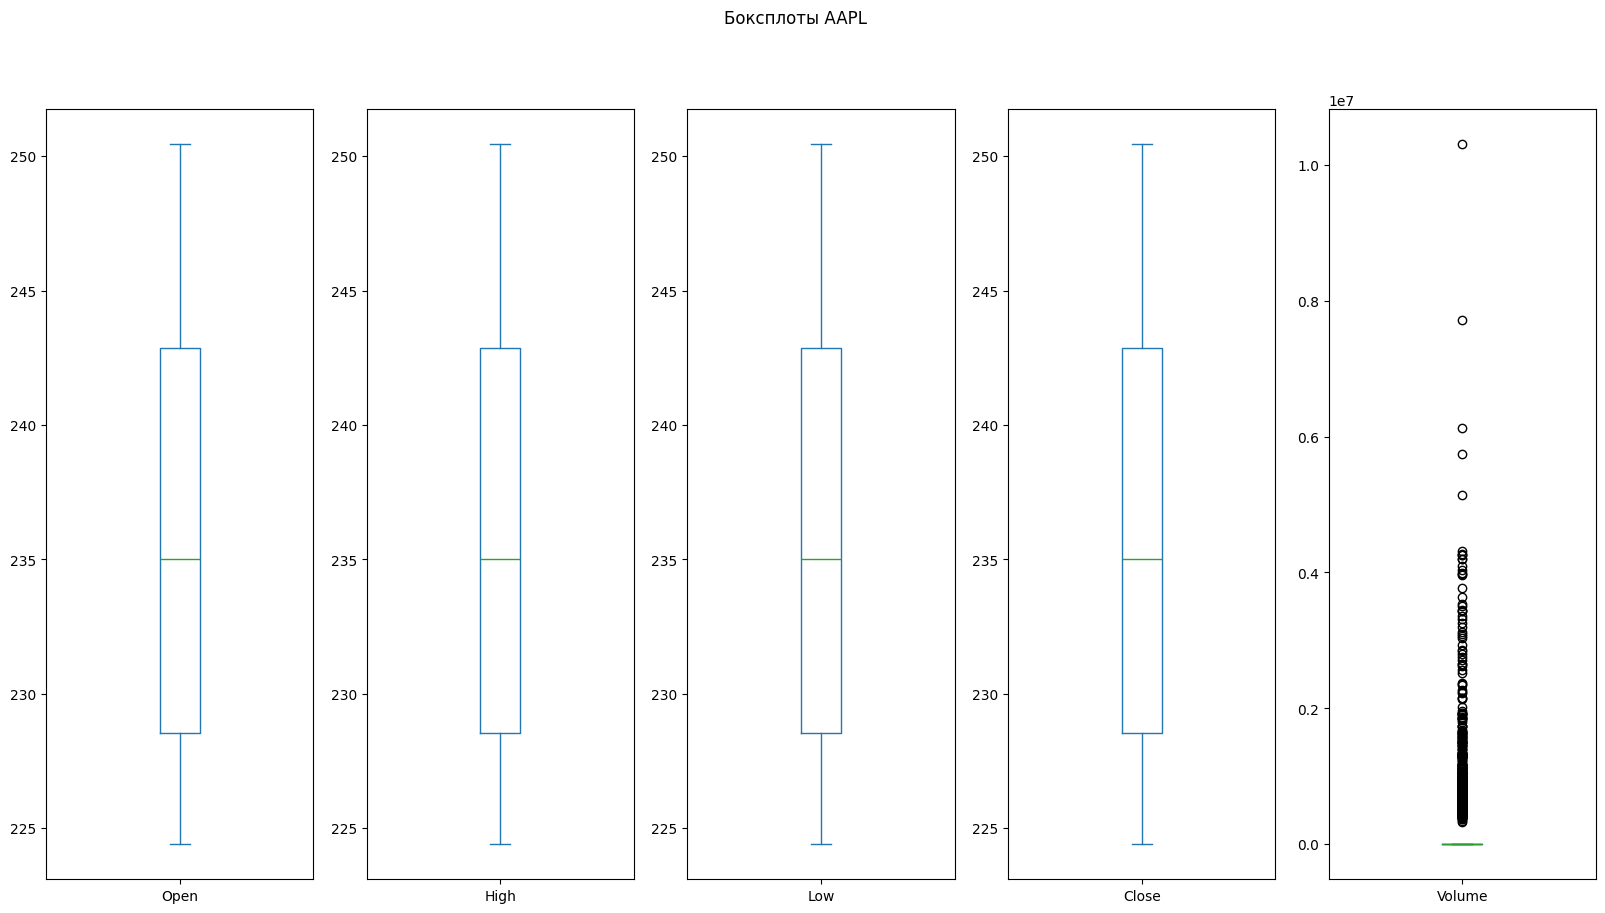

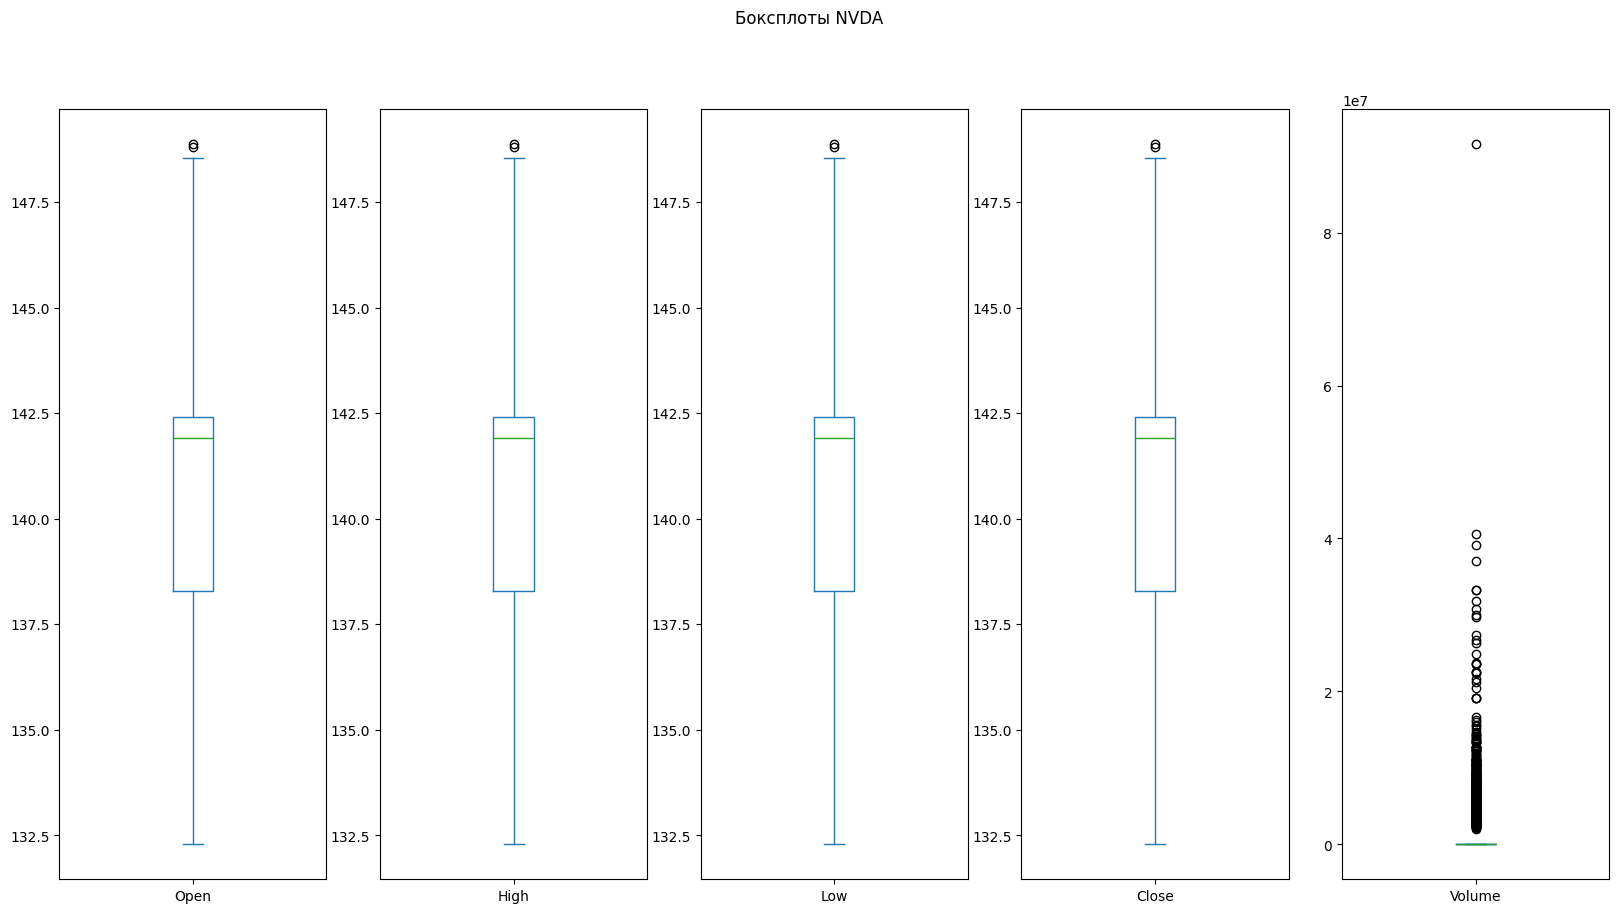

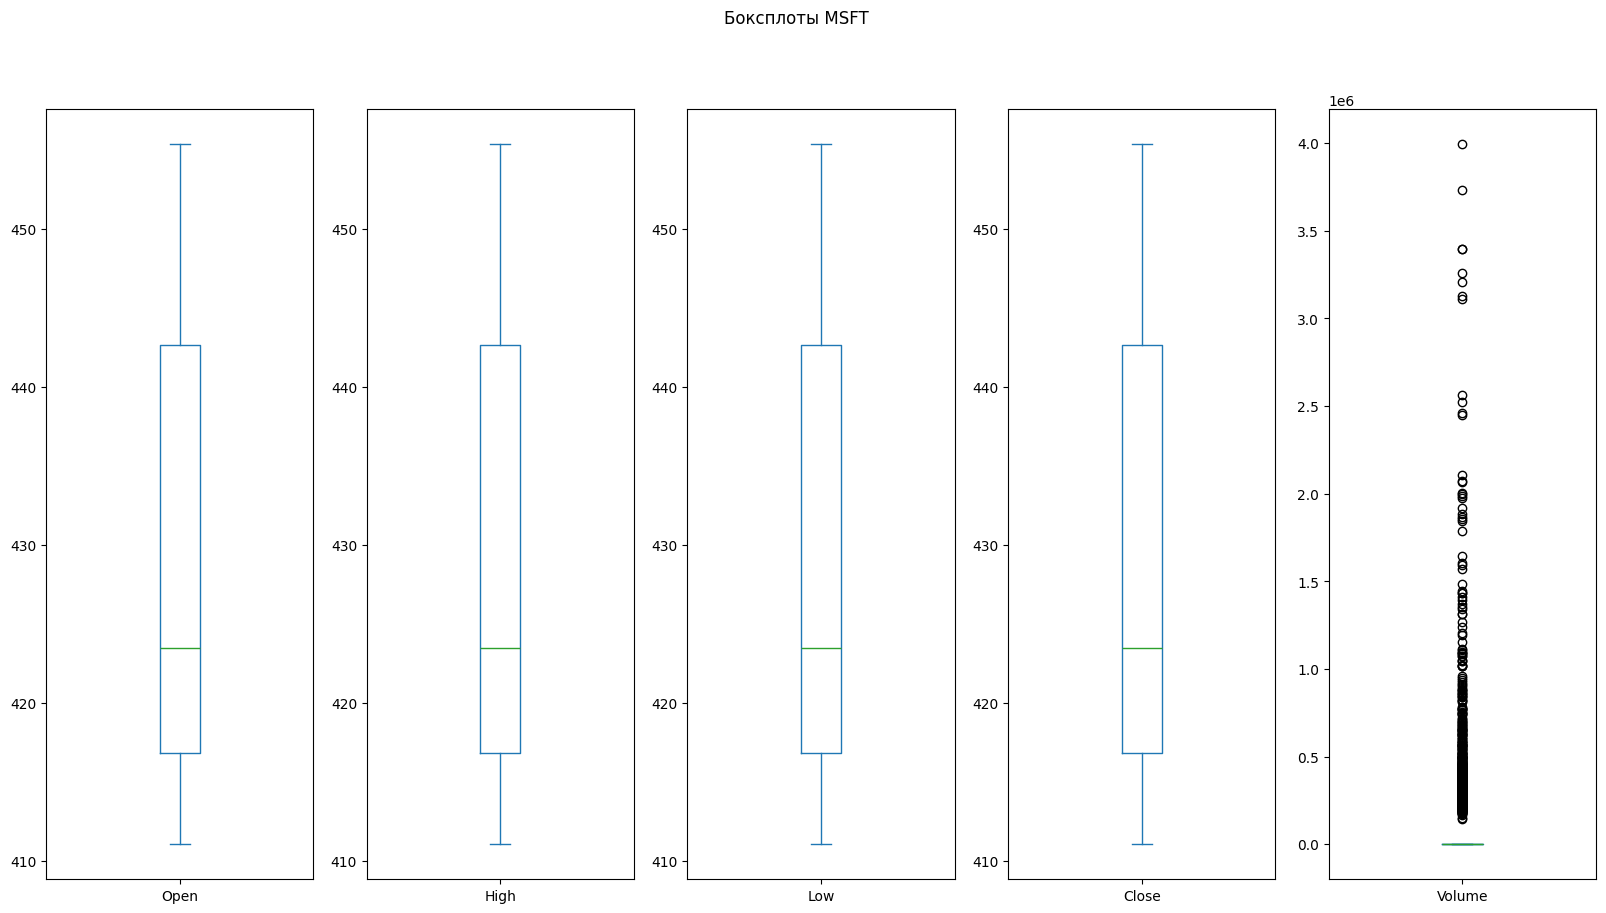

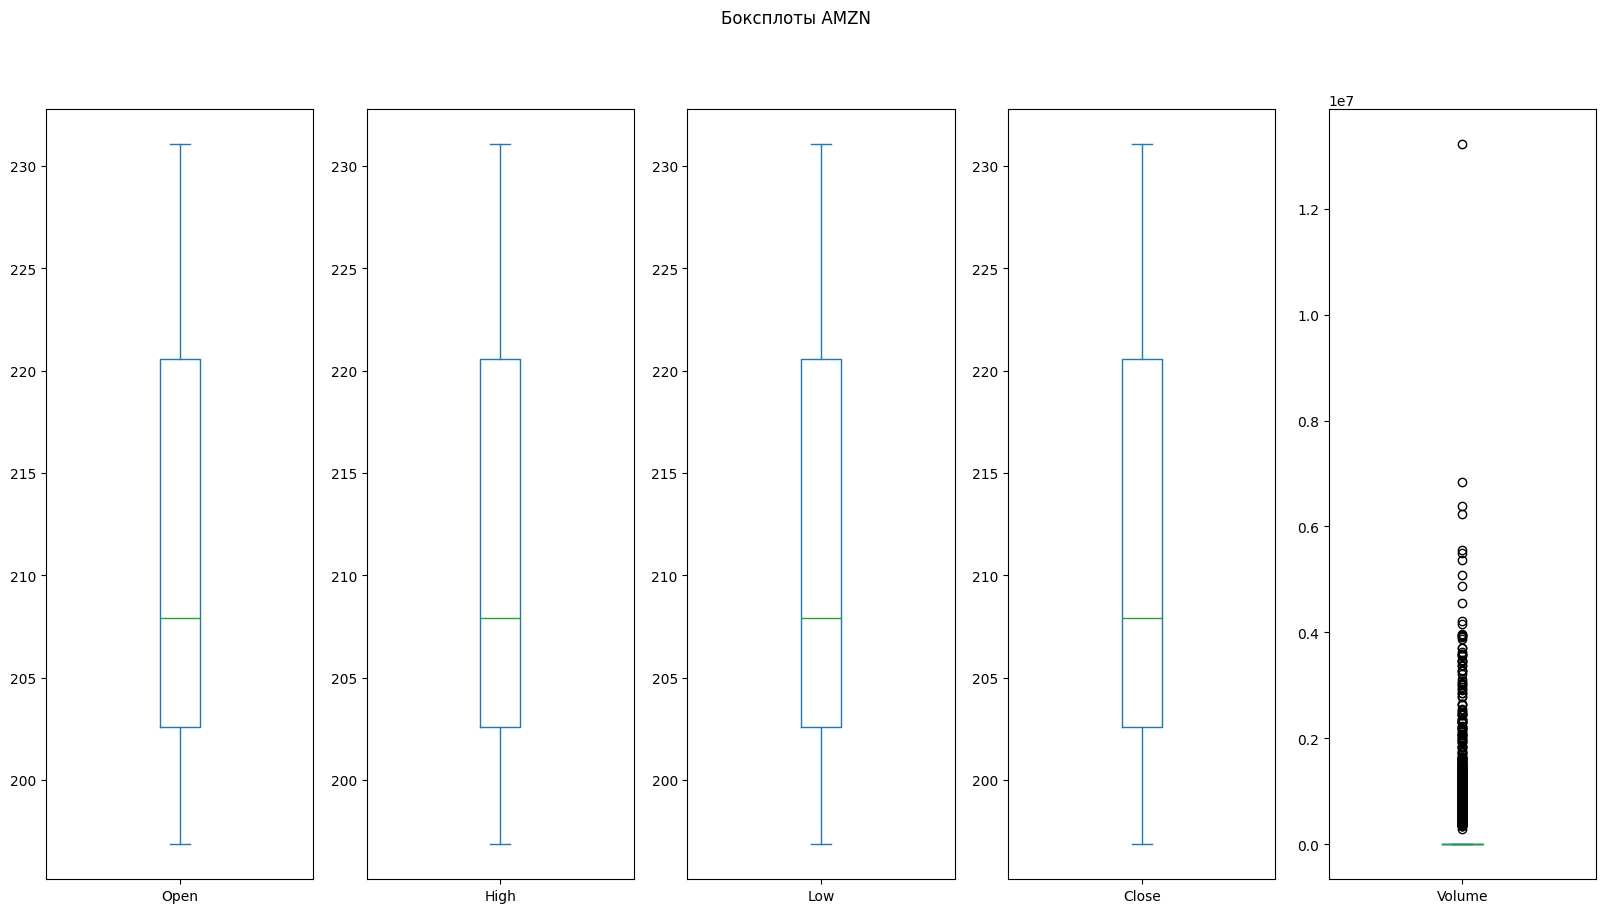

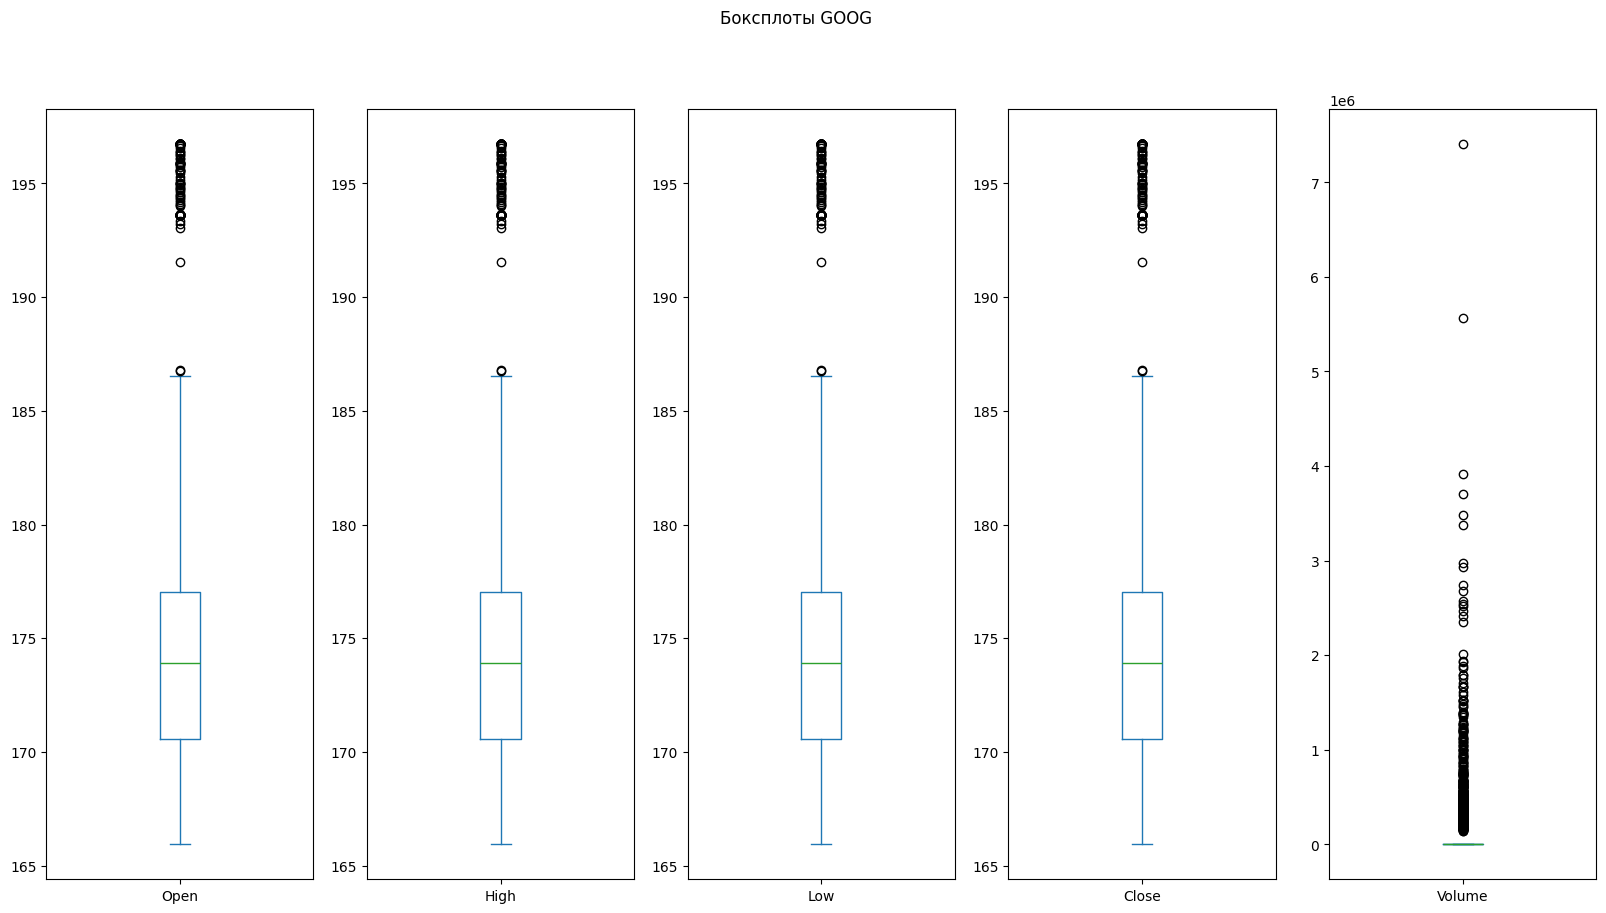

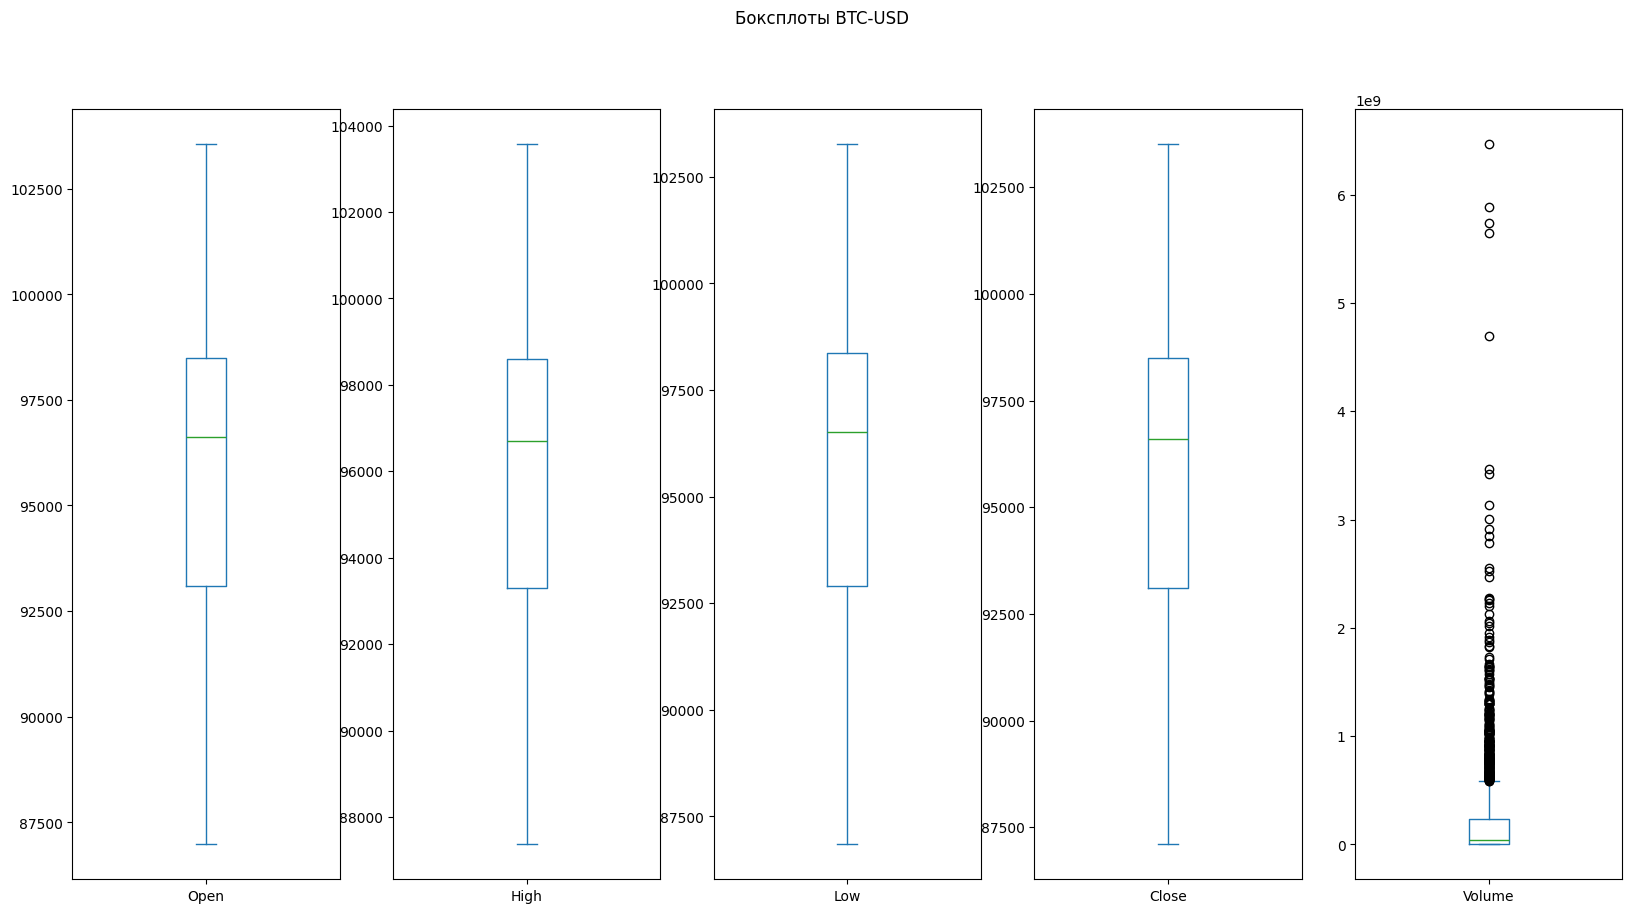

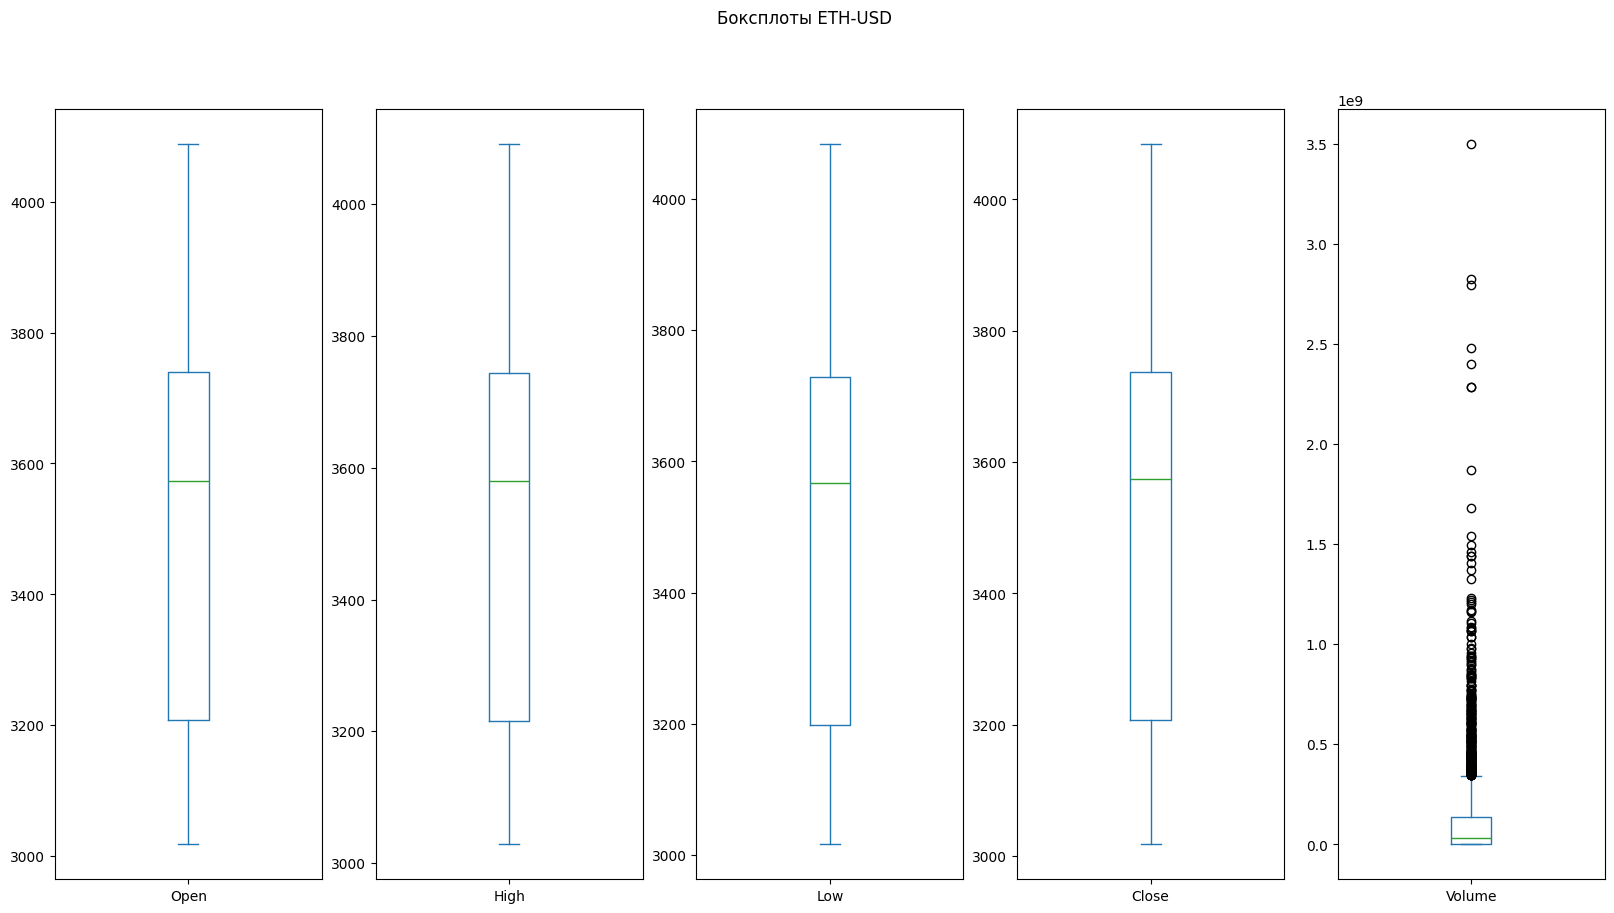

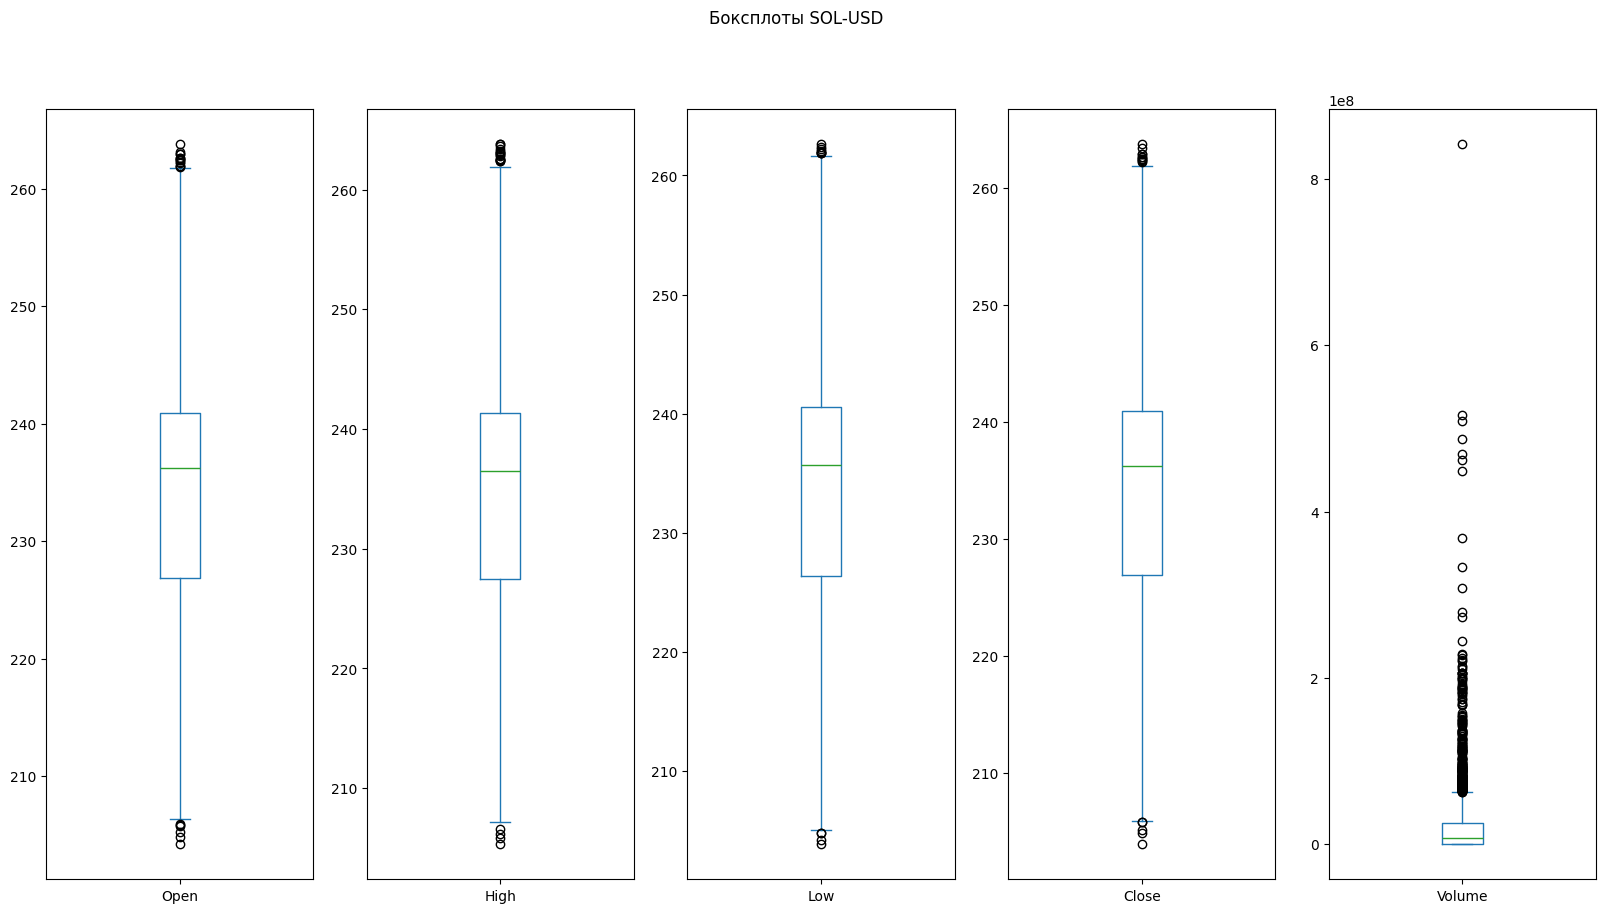

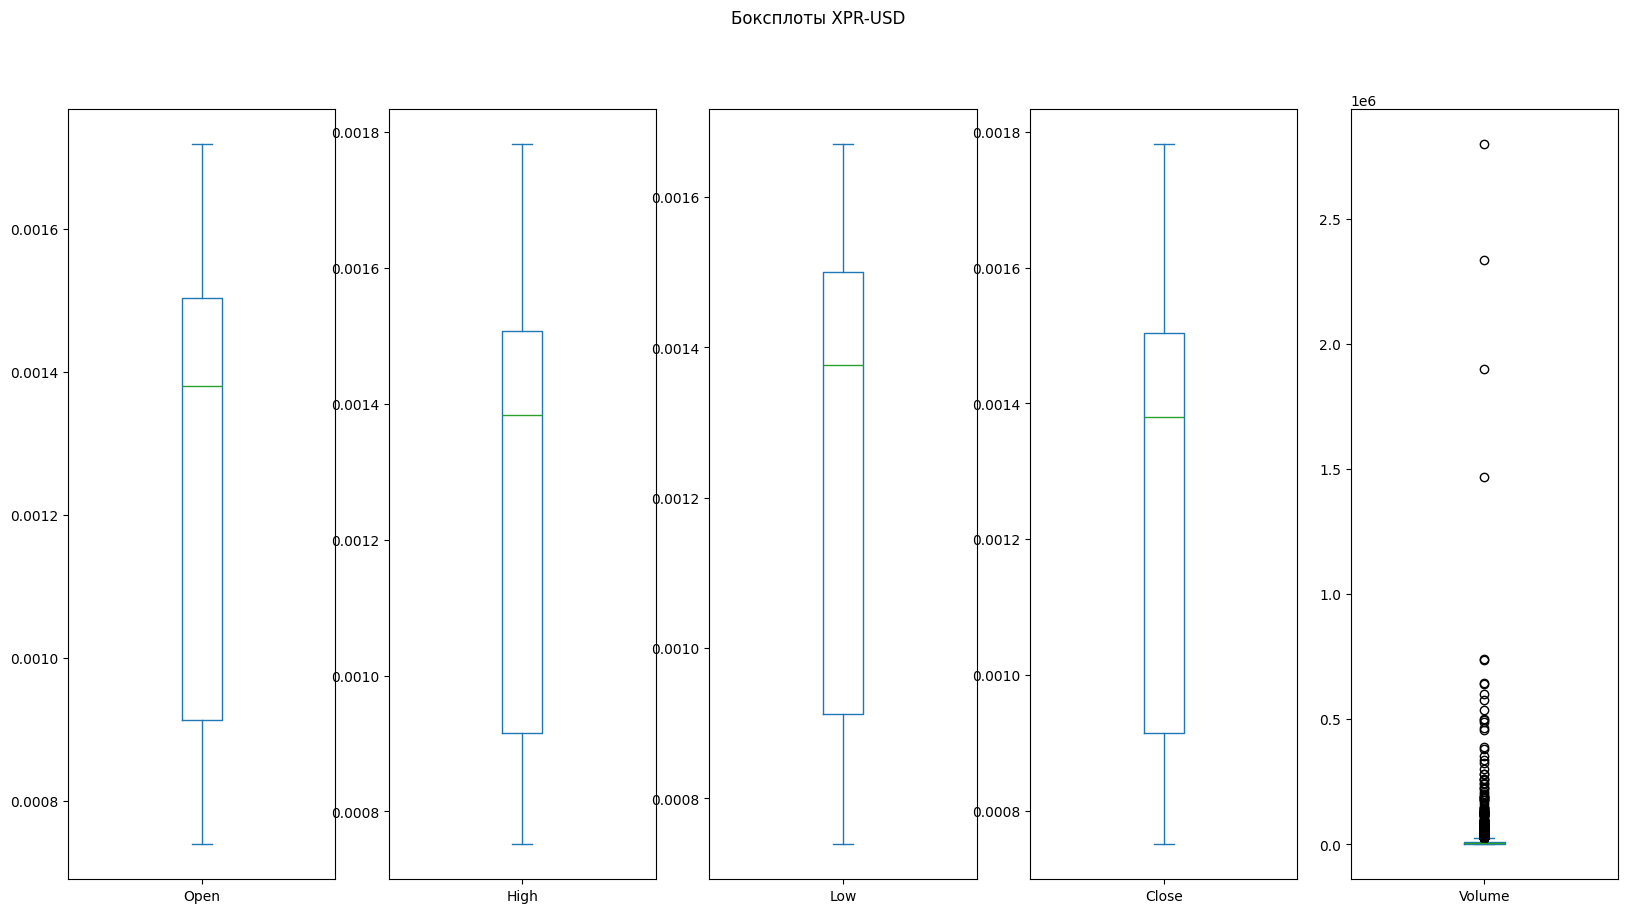

In [18]:
for ticker in tickers_snp_top5 + tickers_ccur:
    df_joined[ticker].plot(kind="box", figsize=(20, 10), subplots=True, title=f"Боксплоты {ticker}")

Боксплоты, построенные по правилу 1.5 * IQR, подсказывают, что в колонках с ценами присутствуют некоторые выбросы, а volume по его мнению - вообще месиво. Но, по моему мнению, речь о выбросах в финансовых данных можно вести только если:
1) инструмент - сильный неликвид, 1-2 странные сделки по нему могут значительно повлиять на данные; и/или
2) источник данных недостоверный, и данные могут быть неправильными 

Ни то, ни другое нас здесь не касается, поэтому я считаю, что в данных выбросов нет и нужно использовать при обучении модели всё, что имеем.